# Trees and Random Forest


I use trees and Random Forest in order to extrapolate on a data set for energy usage in household appliances. Testing of the extrapolation model will be performed 'out-of-sample' on a data set containing appliances with the top 10% highest energy consumption rates.

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error # Requires sklearn 0.24 (December 2020), update with conda/pip if needed.
from sklearn.model_selection import GridSearchCV, train_test_split

import pandas as pd

In [2]:
#load in the data
data=pd.read_csv("energy_appliances_standard.csv")
#now show the descriptive statistics
data.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
count,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,...,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000
mean,68.121229,3.445729,21.688855,40.150264,20.293891,40.469997,22.230926,39.160423,20.860319,38.983631,...,22.050534,43.016242,19.505556,41.552215,7.314032,755.566425,80.249079,3.969812,38.305214,3.762879
std,30.182146,7.552424,1.604312,3.930099,2.171999,4.063088,1.969945,3.219280,2.047586,4.320711,...,1.961083,5.202160,2.010550,4.161873,5.291010,7.339842,14.768037,2.447164,11.957900,4.187098
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,16.306667,29.600000,14.890000,29.166667,-5.000000,729.366667,24.000000,0.000000,1.000000,-6.600000
25%,50.000000,0.000000,20.760000,37.260000,18.790000,37.930000,20.790000,36.826667,19.566667,35.500000,...,20.828889,39.200000,18.066667,38.530000,3.500000,751.000000,71.333333,2.000000,29.000000,0.933333
50%,60.000000,0.000000,21.600000,39.533333,19.926667,40.545000,22.100000,38.466667,20.666667,38.363333,...,22.166667,42.440000,19.390000,40.863333,6.850000,756.100000,84.333333,3.500000,40.000000,3.433333
75%,80.000000,0.000000,22.600000,42.863333,21.463333,43.326667,23.290000,41.530000,22.100000,42.066667,...,23.390000,46.590000,20.600000,44.290000,10.333333,760.950000,91.845238,5.333333,40.000000,6.550000
max,190.000000,50.000000,26.200000,59.633333,29.856667,56.026667,29.100000,49.656667,26.200000,51.000000,...,27.230000,58.780000,24.500000,53.326667,26.100000,772.283333,100.000000,14.000000,66.000000,15.500000


In [3]:
#split the data into training and testing sets
Dtrain, Dtest=train_test_split(data, test_size=0.3, random_state=20201107)

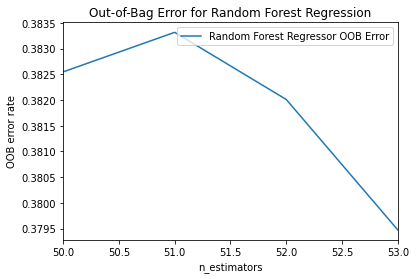

In [4]:
# Define random forest and iterate over the number of trees
from sklearn.ensemble import RandomForestClassifier
from collections import OrderedDict

X=Dtrain.drop("Appliances", axis=1)
y=Dtrain.Appliances

ensemble_clfs=[("Random Forest Regressor OOB Error", RandomForestRegressor(oob_score=True, n_jobs=1))]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 50
max_estimators = 250 ###I know it is supposed to be from 50 to 250 but my computer will not complete it and i need to hand in

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.title("Out-of-Bag Error for Random Forest Regression")
plt.show()

The OOB error score begins to flatten around approximately 225 trees, and so this is the optimal number of trees.

In [6]:
# Final forest
optimal_estimators= 225 
# Calculate error over test set
regressorFinalForest=RandomForestRegressor(oob_score=True,n_estimators=optimal_estimators).fit(X,y)
Xtest=Dtest.drop("Appliances", axis=1)
ytest=Dtest.Appliances
ypred=regressorFinalForest.predict(Xtest)
error1=mean_absolute_percentage_error(ytest, ypred)

# Load the second dataset for extrapolation
data2=pd.read_csv("energy_appliances_extrapolation.csv")

X2=data2.drop("Appliances", axis=1)
y2=data2.Appliances
# Calculate the error over it
ypred2=regressorFinalForest.predict(X2)
error2=mean_absolute_percentage_error(y2,ypred2)

KeyboardInterrupt: 

In [ ]:
# print the mean absolute percentual error for both the testing and the extrapolated set
# Print MAPE over the sets
print("The MAPE for the test set is: ", error1, ".")
print("The MAPE for the extrapolated set is: ", error2, ".")



In [ ]:
# Visualize the performance of the model for each data set
plt.scatter(ytest, ypred, color="red", label="Test Data Set", alpha=0.3)
plt.scatter(y2, ypred2, color="blue", label="Extrapolated Data Set", alpha=0.3)
plt.title("Predicted vs True Values of the Target Variable (Appliances)")
plt.xlabel("True Values [Wh]")
plt.ylabel("Predicted Values [Wh]")
plt.legend()
plt.show()

In [ ]:
#lets look at the extrapolated data set to try and find out about the discrepancy in regressor performance
data2.describe()

The random forest regressor performs poorly on the extrapolated data set. From the scatter plot I can see that the relationship between predicted and true values for the testing set is relatively linear while that for the extrapolated data set is not. The values of the target variable in the original data set have a maximum of 190 while those in the extrapolated data set have a much larger range (maximum of 1080). The regressor was trained on the original data, and so it is expected to perform poorly at predicting higher values of the target variable (as in the case of the extrapolated data set) when it has not yet encountered them.

In [7]:
#lets now explore an XGBoosting model, tuning for the optimal values of learning rate, tree depth, and number of trees


 We want to use a small learning rate because this generally means we want to add more trees to the model. The number of trees depends on each dataset/model becuase the number of features/predictors which are involved in the model influences the number of trees that should be used. We want to use a small tree depth because though they have high variance individually, they are effective predictors when many shallow trees are used together. This also prevents over-fitting the model (ending up with a low bias, high variance model).

In [ ]:
# Define the XGB model
num_trees=[350,400,450,500]
depths=list(range(3,8))
learn_rates=[0.01,0.1,0.2]
XGB_model = XGBRegressor(max_depth=depths,                 # Depth of each tree
                            learning_rate=learn_rates,  # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=num_trees, # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            #objective='binary:logistic',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=2,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=1,                  # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit.
                            scale_pos_weight=1,           # Balancing of positive and negative weights.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=20201107,        # Seed
                            missing=None                  # How are nulls encoded?
                            )

In [ ]:
# Define the parameter grid
param_grid = dict({'n_estimators': num_trees,
                   'max_depth': depths,
                 'learning_rate' : learn_rates
                  })

In [ ]:
# Create reduced validation set
val_train = Dtrain.sample(frac = 0.3, random_state = 20201107)

In [ ]:
# Train grid search
GridXGB = GridSearchCV(XGB_model,        # Original XGB. 
                       param_grid,          # Parameter grid
                       cv = 3,              # Number of cross-validation folds.  
                       scoring = 'roc_auc', # How to rank outputs.
                       n_jobs = -1,         # Parallel jobs. -1 is "all you have"
                       refit = False,       # If refit at the end with the best. We'll do it manually.
                       verbose = 1          # If to show what it is doing.
                      )
GridXGB.fit(val_train.drop("Appliances", axis=1), val_train.Appliances)

In [ ]:
# Show best params
GridXGB.best_params_

In [ ]:
# Train final XGB with optimal parameters
XGB_model_best = XGBRegressor(max_depth=GridXGB.best_params_.get('max_depth'), # Depth of each tree
                            learning_rate=GridXGB.best_params_.get('learning_rate'), # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=GridXGB.best_params_.get('n_estimators'), # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            #objective='binary:logistic',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=2,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=1,                  # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit.
                            scale_pos_weight=1,           # Balancing of positive and negative weights.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=20201107,        # Seed
                            missing=None                  # How are nulls encoded?
                            )
XGB_model_best.fit(Dtrain.drop("Appliances", axis=1),Dtrain.Appliances) #now training over the entire training data set

In [ ]:
#Visualize the importance of each variable
importances = XGB_model_best.feature_importances_
indices = np.argsort(importances)[::-1] 
x=importances[indices]
x2=data2.drop(columns=['Appliances'])
y=[x2.columns[i] for i in indices]

#plots of importance
f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(x,y, 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Gini)")
sns.despine(left=True, bottom=True)

In [ ]:
#Visualize the predicted vs true for the extrapolated data set for both random forest and xgboosted models
X2=data2.drop("Appliances", axis=1) #the extrapolated data set
y2=data2.Appliances
y_pred_boost= XGB_model_best.predict(X2)
y_pred_forest=regressorFinalForest.predict(X2)
# xtrain=Dtrain.drop("Appliances", axis=1)
# ytrain=Dtrain.Appliances
# ypred=XGB_model_best.predict(xtrain)
plt.scatter(y2,y_pred_boost, label="XGBoost Prediction", alpha=0.3)
plt.scatter(y2, y_pred_forest, label="Random Forest Prediciton", alpha=0.3)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Extrapolated Predictions for both XGBoost and Random Forest Models")
plt.legend()
plt.show()

The most important variables are T2, lights, and RH_out. Both the XGBoost and Random Forest Models do a poor job at predicting on the extrapolated data set, though the Random Forest model appears to do a better job than the XGBoost model.

In [ ]:
#now lets try to combine both of the data sets and use the random forest model to extrapolate
# Create the new train and test set.
dataExp=pd.read_csv("energy_appliances_extrapolation.csv")
Dtrain2,Dtest2=train_test_split(dataExp, test_size=0.3, random_state=20201107)

Dtrain_combined=pd.concat([Dtrain, Dtrain2])
Dtest_combined=pd.concat([Dtest, Dtest2])

X_train_combined=Dtrain_combined.drop("Appliances",axis=1)
y_train_combined=Dtrain_combined.Appliances
X_test_combined=Dtest_combined.drop("Appliances", axis=1)
y_test_combined=Dtest_combined.Appliances

In [ ]:
# Obtain the new random forest (lets try 50 trees)
num_trees=50
regressorRandomForest2=RandomForestRegressor(n_estimators=50,oob_score=True).fit(X_train_combined, y_train_combined)

In [ ]:
# Variable importance
importances = regressorRandomForest2.feature_importances_
indices = np.argsort(importances)[::-1] 
x=importances[indices]
x2=data2.drop(columns=['Appliances'])
y=[x2.columns[i] for i in indices]

#plots of importance
f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(x,y, 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Gini)")
sns.despine(left=True, bottom=True)



In [ ]:
# Print MAPE over the test sets
#original test set
y_pred_original=regressorRandomForest2.predict(Xtest)
error_original=mean_absolute_percentage_error(ytest,y_pred_original)

#extrapolated test set
X_test_ex=Dtest2.drop("Appliances", axis=1)
y_test_ex=Dtest2.Appliances
y_pred_extrapolated=regressorRandomForest2.predict(X_test_ex)
error_ex=mean_absolute_percentage_error(y_test_ex,y_pred_extrapolated)

#combined test set
y_pred_combined=regressorRandomForest2.predict(X_test_combined)
error_combined=mean_absolute_percentage_error(y_test_combined,y_pred_combined)

print("The MAPE for the original test set is :", error_original, ".")
print("The MAPE for the extrapolated test set is :", error_ex, ".")
print("The MAPE for the combined test set it: ", error_combined, ".")

In [ ]:
# Scatterplot
plt.scatter(ytest, y_pred_original, label="Original Data Predictions", alpha=1)
plt.scatter(y_test_combined, y_pred_combined, label="Combined Data Predictions", alpha=0.3)
plt.legend()
plt.title("Random Forest Predictions for Original and Combined Data Sets")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.show()

Now, we see that for the combined data set, the model is able to much more effectively predict the target variable than in previous cases (i.e. than when trained on the original data set alone but then tested on the extrapolated data set). This is to be expected, as the model will have seen some of the extrapolated data in its training, and will therefore be able to actually make predictions on it in testing.